# Important note
This notebook utilizes computationally intensive models such as:
- Huggingface pipelines for sentiment analysis
- BERTopic for topic modelling

We encourage using GPU (Google Colab) when running the code below. If you choose not to, the code should still function properly, albiet slower.

In [ ]:
# Boilerplate code to set up on Google Colab

# Step 1) Add Google Drive as an accessible path
# from google.colab import drive
# drive.mount('/content/drive')

# Step 2) Change path to the designated google drive folder (e.g., %cd /content/drive/My Drive/Colab Notebooks/IS434_G1T5/analysis)
# %cd /content/drive/My Drive/Colab Notebooks/IS434_G1T5/analysis

# Import relevant libraries and files

In [44]:
import os
from os import path
import re
import string

import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from sklearn.metrics import classification_report

from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt


from transformers import pipeline
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [6]:
# Download stopwords
nltk.download('stopwords')

# Variable 'stop' set to list of english stopwords from nltk library
stop = stopwords.words('english')

#adding stop words
stop.extend(['ngl','lol','thats','theyre','tbh','idk','rall','theres','youre','yall','dont','aint','ive','arent','havent','wtf','thatll','omg','theyd','woah','fucking','wouldve','shit','wouldve','werent','repost','deleted','heres','wouldnt','fuck','cant','haha'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [19]:
reviews = pd.read_csv("./combined_reviews.csv", encoding="unicode_escape")

In [20]:
reviews.head()

,reviews
0,Sukiyaki Beef is good. \r\n\r\nSpicy garlic po...
1,"One of my fav store for pork collar. However, ..."
2,"Delicious food, prompt delivery and excellent ..."
3,Super valued for money. Super affordable but y...
4,Definitely a surprise find at punggol. Really ...


# Sentiment Analysis with HuggingFace

In [21]:
def clean_text(text):
    """
    Standardlize capitalization to lower,
    Remove punctuations,
    Remove URLs,
    Remove numbers, and words containing numbers,
    Remove redundant whitespace (e.g. double whitespaces, \n, \t),
    Remove stopwords
    """
    # Lowercase
    text = text.lower()
    # Remove punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove numbers, and words containing numbers 
    text = re.sub("[^a-z0-9]"," ", text)
    text = ''.join([i for i in text if not i.isdigit()])
    # Remove redundant whitespace
    text = " ".join(text.split())
    return ' '.join([word for word in text.split() if word not in (stop)])
    

In [22]:
reviews["cleaned_reviews"] = reviews['reviews'].apply(clean_text)
reviews

,reviews,cleaned_reviews
0,Sukiyaki Beef is good. \r\n\r\nSpicy garlic po...,sukiyaki beef good spicy garlic pork cutlet go...
1,"One of my fav store for pork collar. However, ...",one fav store pork collar however today pieces...
2,"Delicious food, prompt delivery and excellent ...",delicious food prompt delivery excellent service
3,Super valued for money. Super affordable but y...,super valued money super affordable yet restau...
4,Definitely a surprise find at punggol. Really ...,definitely surprise find punggol really afford...
...,...,...
118,The element that sealed the deal for us was th...,element sealed deal us runny egg simmered dash...
119,The soft scrambled eggs with onion was perfect...,soft scrambled eggs onion perfectly cooked
120,Their rice bowls could definitely do with more...,rice bowls could definitely sauce
121,Felt that the Asian Fusion Donburi branding ...,felt asian fusion donburi branding bit far str...


In [23]:
# Drop duplicates from cleaned reviews
cleaned_reviews = reviews[["cleaned_reviews"]]
cleaned_reviews = cleaned_reviews.drop_duplicates(subset='cleaned_reviews', keep ='first')
cleaned_reviews

,cleaned_reviews
0,sukiyaki beef good spicy garlic pork cutlet go...
1,one fav store pork collar however today pieces...
2,delicious food prompt delivery excellent service
3,super valued money super affordable yet restau...
4,definitely surprise find punggol really afford...
...,...
108,impressed pork belly katsu opted
109,chunks fresh local tomatoes japanese cucumber ...
111,beef tender unctuous
112,onsen egg yolk already overcooked


In [29]:
cleaned_reviews_list = cleaned_reviews["cleaned_reviews"].to_list()
cleaned_reviews_list[:3]

['sukiyaki beef good spicy garlic pork cutlet good prom belly katsu good thunder fries mentai sauce sibei good',
 'one fav store pork collar however today pieces burnt meat',
 'delicious food prompt delivery excellent service']

In [33]:
# Load the "sentiment prediction" model.
classifier = pipeline("sentiment-analysis", model="siebert/sentiment-roberta-large-english")

# input: sentence
# output: sentiment label and score
sentiment_list = classifier(cleaned_reviews_list)
zipped_list = []

for i in range(len(cleaned_reviews_list)):
    zipped = [cleaned_reviews_list[i], sentiment_list[i]['label'], sentiment_list[i]['score']]
    zipped_list.append(zipped)

sentiment_df = pd.DataFrame(zipped_list, columns=['comment','sentiment','sentiment score'])

Downloading:   0%|          | 0.00/687 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [34]:
sentiment_df.head()

,comment,sentiment,sentiment score
0,sukiyaki beef good spicy garlic pork cutlet go...,POSITIVE,0.998703
1,one fav store pork collar however today pieces...,NEGATIVE,0.999418
2,delicious food prompt delivery excellent service,POSITIVE,0.998911
3,super valued money super affordable yet restau...,POSITIVE,0.998891
4,definitely surprise find punggol really afford...,POSITIVE,0.998924


# Evaluation for validity of pre-trained model
To mitigate the issue of having non-labelled data, we utilize pre-trained transformers.<br><br>Our model - <b>siebert/sentiment-roberta-large-english</b> - was fine-tuned and evaluated on 15 data sets from diverse text sources to enhance generalization across different types of texts (reviews, tweets, etc.) and outperforms SST-2 benchmarks.<br><br>
However, to test the validity of this model on our dataset, we manually label some data an run a classification report

In [37]:
labelled_reviews = pd.read_csv("combined_reviews_LABELLED.csv", encoding="unicode_escape")

In [41]:
labelled_reviews = labelled_reviews.drop_duplicates(subset = 'review', keep='first')

In [43]:
labelled_reviews.head()

,review,sentiment
0,Sukiyaki Beef is good. \r\n\r\nSpicy garlic po...,POSITIVE
1,"One of my fav store for pork collar. However, ...",POSITIVE
2,"Delicious food, prompt delivery and excellent ...",POSITIVE
3,Super valued for money. Super affordable but y...,POSITIVE
4,Definitely a surprise find at punggol. Really ...,POSITIVE


In [45]:
y_true = labelled_reviews['sentiment']
y_pred = sentiment_df['sentiment']
target_names  = ['POSITIVE','NEGATIVE']
cf_matrix = classification_report(y_true, y_pred, target_names=target_names)
print(cf_matrix)

              precision    recall  f1-score   support

    POSITIVE       0.65      0.81      0.72        21
    NEGATIVE       0.95      0.90      0.93        92

    accuracy                           0.88       113
   macro avg       0.80      0.86      0.83       113
weighted avg       0.90      0.88      0.89       113



# Generate Wordclouds for positive and negative reviews 

<b>Notes</b>
- BERTopic does not work very well, probably because of lack of data
- May have to explore other libraries

<b>TODO</b>
- bi-gram wordclouds
- POS tagging cleaning for wordcloud (filter non-noun/verb/adjective words possibly)
- Justify embedding model for BERTopic
- Coherence score for BERTopic

In [49]:
positive_df = sentiment_df[sentiment_df["sentiment"] == "POSITIVE"]
negative_df = sentiment_df[sentiment_df["sentiment"] == "NEGATIVE"]

## Wordcloud for positive reviews

(-0.5, 1399.5, 799.5, -0.5)

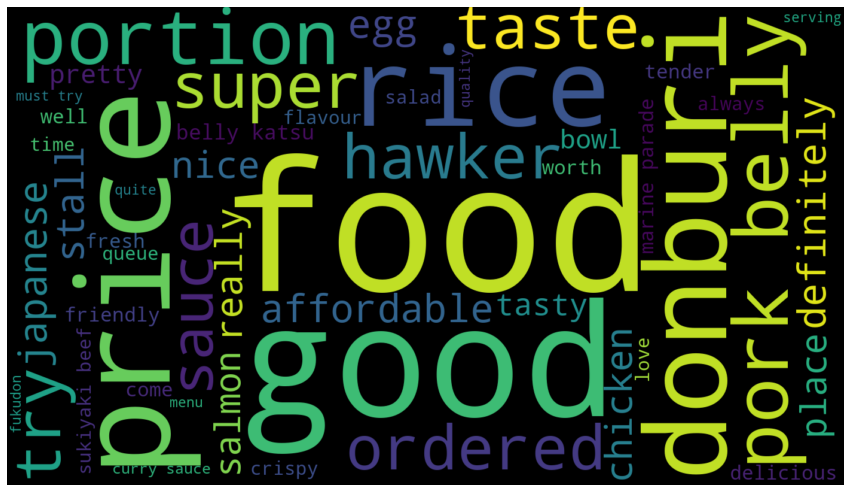

In [67]:
plt.figure(figsize=(15,15))
wc = WordCloud(background_color="black", stopwords = set(stop), max_words=50, max_font_size= 300,  width=1400, height=800)
wc.generate(" ".join(positive_df["comment"].to_list()))

plt.imshow(wc.recolor( colormap= 'viridis' , random_state=20), interpolation="bilinear")
plt.axis('off')

## Wordcloud for negative reviews

(-0.5, 1399.5, 799.5, -0.5)

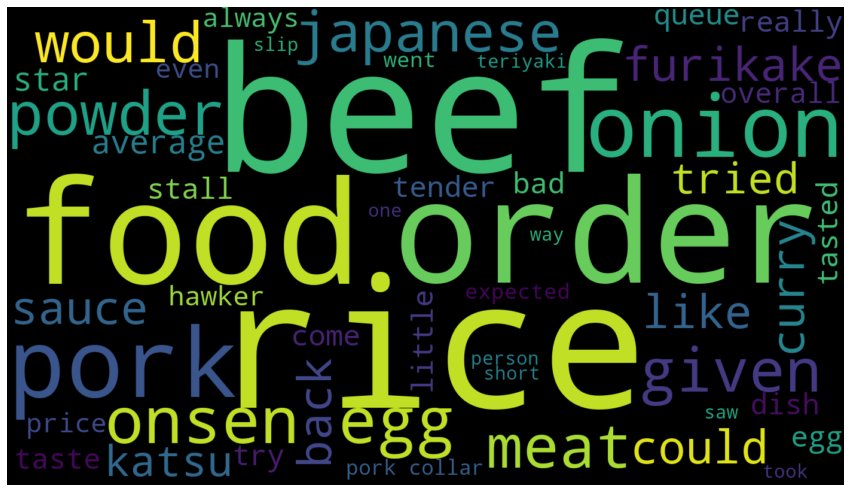

In [69]:
plt.figure(figsize=(15,15))
wc = WordCloud(background_color="black", stopwords = set(stop), max_words=50, max_font_size= 300,  width=1400, height=800)
wc.generate(" ".join(negative_df["comment"].to_list()))

plt.imshow(wc.recolor( colormap= 'viridis' , random_state=20), interpolation="bilinear")
plt.axis('off')

# Topic Modelling with BERTopic

In [72]:
from bertopic import BERTopic

In [76]:
sentiment_df.head()

,comment,sentiment,sentiment score
0,sukiyaki beef good spicy garlic pork cutlet go...,POSITIVE,0.998703
1,one fav store pork collar however today pieces...,NEGATIVE,0.999418
2,delicious food prompt delivery excellent service,POSITIVE,0.998911
3,super valued money super affordable yet restau...,POSITIVE,0.998891
4,definitely surprise find punggol really afford...,POSITIVE,0.998924


In [98]:
topic_model = BERTopic(embedding_model="all-MiniLM-L6-v2", nr_topics="auto")
topics, probs = topic_model.fit_transform(sentiment_df["comment"].tolist())

In [101]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,59,-1_food_beef_rice_pork
1,0,31,0_pork_sauce_curry_salmon
2,1,23,1_food_nice_affordable_good
